# Data exploration & feature engineering

In [1]:
from collections import Counter
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load('en_core_web_sm')

from config import TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE, N_GRAM
from helper import train_validation_test_data

pd.set_option('max_colwidth', 120)

In [2]:
x_train, x_validation, x_test, y_train, y_validation, y_test = train_validation_test_data()

In [3]:
print(TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE)

5000 1000 1000


The size of the dataset used is limited to the numbers above (set in `config.py`), otherwise training will take too long on my laptop.

$X$ is a vector of strings containing the comments.

In [4]:
pd.DataFrame(x_train).head()

,comment_text
101404,"""\n\nthe words """"last warning"""" were found a total of 5 times on this page"""
3899,It must be from something since there is a very similar campaign clip from a US democrat candidate (Barrack Obama or...
138269,"""\n\n Hugo Margenat \n\nFound an Image Tony, Also, the Image was part of a Claridad article which you may use to fur..."
108881,My apologies. Got distracted with other matters. Will try to resolve them as soon as I can.
100261,Just chipping in here: is an RfC which instructs people to read 24 previous discussions actually going to attract an...


$Y$ is a matrix containing the binary labels. Since this is a multi-label classification problem each instance can be of multiple labels.

In [5]:
y_train[y_train.sum(axis=1) > 1].head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
37507,1,1,1,0,1,0
61997,1,0,0,0,1,0
18526,1,0,1,0,1,0
9920,1,0,1,0,0,0
118857,1,1,1,0,1,0


As we can see below the label frequencies are quite unbalanced, so we might need to do some feature engineering later on to avoid getting bias or low score in some labels.

toxic            476
severe_toxic      52
obscene          269
threat             5
insult           267
identity_hate     43
dtype: int64


<BarContainer object of 6 artists>

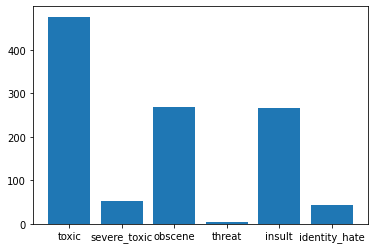

In [6]:
print(y_train.sum())
plt.bar(range(y_train.shape[1]), y_train.sum(), tick_label=y_train.columns)

## 1. Most and least common tokens

In [7]:
def tokens_generator(corpus):
    for text in corpus:
        doc = nlp(text)
        for token in doc:
            yield token.lemma_.lower()

tok_counter = Counter(tokens_generator(x_train))

In [8]:
# Tokens with the highest frequency
print(tok_counter.most_common(50))

[('-pron-', 28372), ('be', 16287), ('.', 15652), (',', 15050), ('the', 15048), ('"', 11669), ('to', 9227), ('of', 6827), ('and', 6654), ('a', 6390), ('not', 5134), ('that', 5082), ('in', 4281), ('have', 4136), (' ', 3910), ('do', 3642), ('\n\n', 3364), ('for', 3301), ('this', 2914), ('on', 2767), (')', 2645), ('\n', 2506), ('-', 2484), ('as', 2419), ('(', 2409), ('article', 2283), ('?', 2174), (':', 2140), ('!', 2015), ('with', 1839), ('if', 1771), ('page', 1706), ('or', 1632), ('but', 1593), ('can', 1426), ('wikipedia', 1392), ('an', 1284), ('about', 1260), ('at', 1245), ('by', 1241), ('will', 1232), ('from', 1229), ('talk', 1151), ('what', 1149), ('there', 1122), ('so', 1073), ('edit', 1037), ("'", 1027), ("'s", 1000), ('use', 996)]


In [9]:
# Number of tokens that only appear once
n_unary = list(tok_counter.values()).count(1)
n_unary

11972

In [10]:
word_freqs = pd.DataFrame(np.sort(np.array(list(tok_counter.values())))[::-1], columns=['freq'])
word_freqs.describe()

,freq
count,21458.000000
mean,18.839966
std,334.084026
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,28372.000000


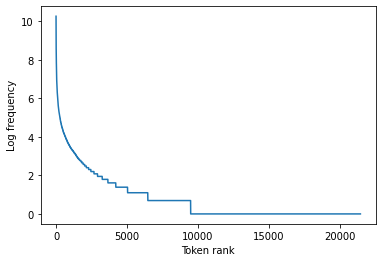

In [11]:
# Most words occurs very rarely
plt.xlabel('Token rank')
plt.ylabel('Log frequency')
plt.plot(range(word_freqs.size), np.log(word_freqs['freq']))

### Aggregate tokens between cutoff points for stopword/rare-word removal

We will retain informative tokens instead of removing most/least common tokens.

In [12]:
CUTOFF_HI = 500
CUTOFF_LO = 2

informative_tokens = set(
    map(lambda x: x[0],  # Get the token itself
        filter(lambda x: CUTOFF_LO <= x[1] < CUTOFF_HI,  # Filter predicate
               list(tok_counter.items()))))

# Write to disk for later use
with open('informative_tokens.pickle', 'wb') as f:
    pickle.dump(informative_tokens, f)

print(len(informative_tokens))

9394


## 2. N-gram

In [13]:
def n_gram_generator(corpus, n=2):
    for text in corpus:
        doc = nlp(text)
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha]
        if len(tokens) > n:
            for i in range(0, len(tokens) - n + 1):
                yield ' '.join(tokens[i:i+n])

n_gram_counter = Counter(n_gram_generator(x_train, N_GRAM))

In [14]:
n_gram_freqs = pd.DataFrame(np.sort(np.array(list(n_gram_counter.values())))[::-1], columns=['freq'])

# Number of bi-grams that occured more than once
n_gram_freqs[n_gram_freqs > 1].count()[0]

28588

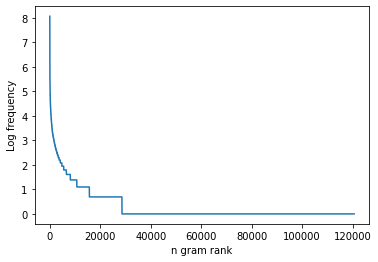

In [15]:
plt.xlabel('n gram rank')
plt.ylabel('Log frequency')
plt.plot(range(n_gram_freqs.size), np.log(n_gram_freqs['freq']))

In [20]:
print(n_gram_counter.most_common(10))

[('-pron- be', 3170), ('of the', 1575), ('-pron- have', 1477), ('-pron- do', 1254), ('that -pron-', 1230), ('if -pron-', 1206), ('be a', 1137), ('in the', 1137), ('be not', 871), ('-pron- can', 870)]


In [24]:
N_GRAM_CUTOFF_HI = 200
N_GRAM_CUTOFF_LO = 6

informative_ngrams = set(
    map(lambda x: x[0],  # Get the n_gram itself
        filter(lambda x: N_GRAM_CUTOFF_LO <= x[1] < N_GRAM_CUTOFF_HI,  # Filter predicate
               list(n_gram_counter.items()))))

# Write to disk for later use
import pickle
with open('informative_ngrams.pickle', 'wb') as f:
    pickle.dump(informative_ngrams, f)

print(len(informative_ngrams))

6459
